В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням Decision Trees і зробимо новий submission на змагання на Kaggle.

В цьому ДЗ ми працюємо без pipelines, бо так буде зручніше для візуалізації і інтерпретації моделі дерева прийняття рішень. Так буває і в робочих проєктах: іноді зручніше використати sklearn.Pipelines, іноді зручніше без них. На етапі пошуку рішення (research) зручніше без пайплайнів, а з пайплайнами - коли ви відлагодили процес обробки даних і хочете поекспериментувати з різними моделями і гіперпараметрами.

**Завдання 1.**

У попередньому домашньому завданні, `HW 2.7 Логістична регресія з scikit learn.ipynb`, ми писали обробку даних для змагання. Ваше завдання зараз - за прикладом, наведеним в лекції `Майстер-клас з перенесення коду з jupyter notebook у Python модуль`, перенести попередню обробку сирих даних з вашого розв'язку ДЗ 2.7 у файл `process_bank_churn.py` в функцію `preprocess_data(...)`.

Функція `preprocess_data()` має приймати `raw_df` і вертати `X_train`, `train_targets`, `X_val`, `val_targets`, `input_cols`(перелік назв колонок, які Ви використовуєте в X), `scaler`, `encoder`, які ми потім будемо використовувати для тренування дерева прийняття рішень.


### Кроки попередньої обробки:

1. Обираємо колонки для роботи. В цьому завдання для чистоти експериментів рекомендую прибрати колонку `Surname`, так буде простіше інтрепретувати модель. Ви можете її додати вже за самостійних подальших експериментів.
2. Розбиття сирих даних на тренувальні і валідаційні.
3. Обробка категоріальних даних (one hot encoding).
4. Масштабування числових даних (було частиною попередньої обробки в попередніх завданнях). Для дерев нам не обовʼязково масштабувати ознаки, тож в коді можна зробити цю частину опціональною, додавши в `preprocess_data` параметр `scaler_numeric`, який приймає значення `True` або `False`. Це дозволить використовувати код попередньоъ обробки з різними моделями.


### Інструкції:
1. Перенесіть попередню обробку даних у файл `process_bank_churn.py`.
2. Забезпечте модулярну структуру функцій: кожна функція повинна виконувати лише одну дію, наприклад, масштабувати ознаки.
3. Додайте докстрінги до кожної функції.
4. Використовуйте typing для аргументів та значень, що повертаються функціями.
5. Передбачте обробку нових даних. Додайте спеціальну функцію `preprocess_new_data(...)`, яка приймає на вхід нові дані в вигляді pandas DataFrame та використовує вже навчені скейлер та енкодер (передані теж як аргументи фукнціх) для їх обробки. Ця функція буде корисною для обробки нових даних перед передбаченням або оцінкою моделі, коли оброблятимемо `test.csv`.

Можна і рекомендовано виконувати це завдання з ChatGPT (бажано, новіше, ніж 3.5) як було наведено у відео-прикладі, тільки **ваше додаткове завдання - розібратись з кодом, який вам згенерувала мовна модель :)**.

## В результаті цього завдання

1. Завантажте ваш готовий `process_bank_churn.py` файл на GitHub у свій репозиторій.
2. Додайте посилання на файл в репозиторії тут у ноутбуці.
3. Нижче зробіть імпорт функції `preprocess_data` з вашого модуля `process_bank_churn.py`.



In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import os
from process_bank_churn import preprocess_data, preprocess_new_data
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree, export_text
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.tree import plot_tree, export_text
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [2]:
def plot_roc_auc_and_confusion_matrix(targets, preds, name):
    fpr, tpr, thresholds = roc_curve(targets, preds, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}")

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
    plt.legend(loc="lower right")
    plt.show()

    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')

    # Plot the Confusion Matrix

    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()

Посилання на файл process_bank_churn.py https://github.com/Lyudas9/ML-course/blob/main/process_bank_churn.py

In [3]:
raw_df = pd.read_csv('bank-customer-churn-prediction-dlu/train.csv', index_col=0)
X_train, y_train, X_val, y_val, scaler, imputer = preprocess_data(raw_df, scale_numeric=False)

In [4]:
X_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_encoded,Gender_Type_Code
7611,588.0,41.0,2.0,0.00,2.0,0.0,0.0,114522.68,0.602133,1.0
14633,704.0,40.0,5.0,129974.79,1.0,1.0,0.0,131768.98,0.177667,0.0
8169,710.0,33.0,3.0,0.00,2.0,0.0,1.0,103570.80,0.602133,1.0
6609,648.0,37.0,8.0,0.00,2.0,1.0,1.0,104469.08,0.602133,0.0
7553,573.0,44.0,3.0,0.00,2.0,1.0,1.0,171457.06,0.602133,1.0
...,...,...,...,...,...,...,...,...,...,...
1992,646.0,29.0,3.0,0.00,2.0,0.0,0.0,140941.47,0.602133,1.0
9347,627.0,35.0,6.0,0.00,2.0,1.0,0.0,55775.72,0.602133,1.0
9131,693.0,34.0,1.0,0.00,2.0,1.0,0.0,95583.45,0.602133,0.0
7057,719.0,29.0,7.0,68432.45,1.0,0.0,0.0,89048.46,0.602133,0.0


**Завдання 2.**
1. Натренуйте дерево прийняття рішень з зафіксованим `random_state` і з рештою аргументів за замовченням.
2. Виведіть area under ROC для моделі на тренувальних і тестувальних даних. Нам потрібна ця метрика, бо вона основна в змаганні. Модель ок, чи є пере- або недотренування?
3. Виведіть глибину дерева.
4. Побудуйте дерево до глибини 2 включно. Напишіть, які ознаки бачите, що є найвпливовішими тут?
5. Створіть датафрейм `importance_df` з feature importances, де в першому стовпчику `feature` - назва ознаки з нашого Х, а в другому `importance` - значення, наскільки ця ознака є важливою в побудованій моделі. Виведіть топ 10 найвпливовіших ознак разом з їх скором важливості (можна або у вигляді таблиці, або в вигляді barplot).

Натренуємо дефолтну модель та порахуємо метрики area under ROC та Confusion Matrix.

In [5]:
%%time
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

Wall time: 50.5 ms


DecisionTreeClassifier(random_state=42)

In [6]:
train_preds = model.predict(X_train)

In [7]:
pd.value_counts(train_preds)

0.0    7646
1.0    1954
dtype: int64

In [8]:
accuracy_score(y_train, train_preds)

1.0

In [9]:
model.score(X_val, y_val)

0.8404166666666667

Area under ROC score on Train dataset dataset: 1.00


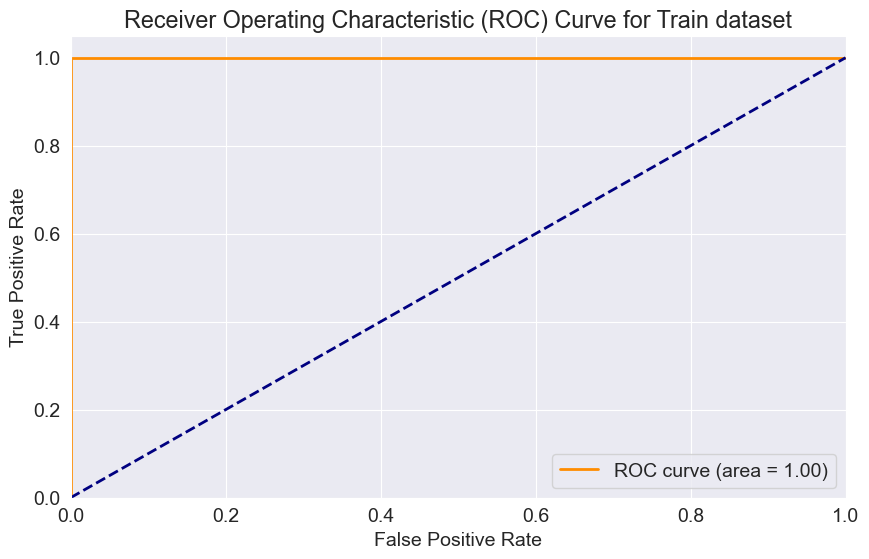

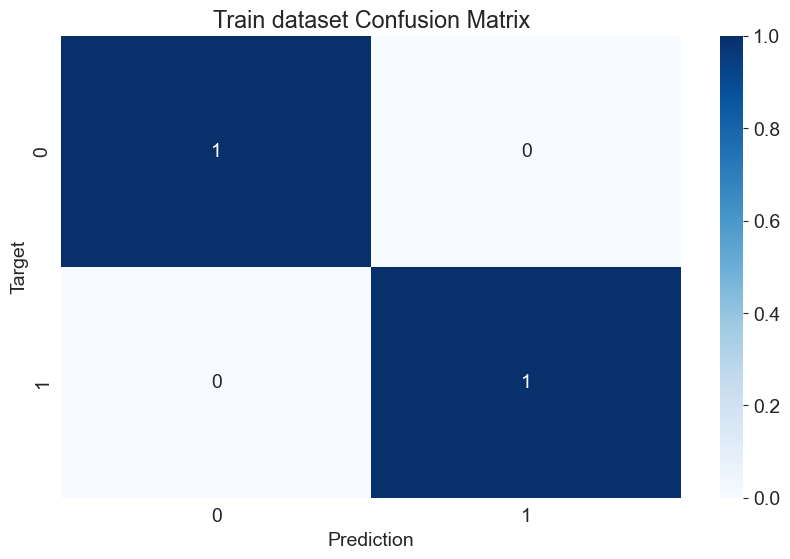

In [10]:
plot_roc_auc_and_confusion_matrix(y_train, train_preds, "Train dataset")

Area under ROC score on Valiadtion dataset dataset: 0.76


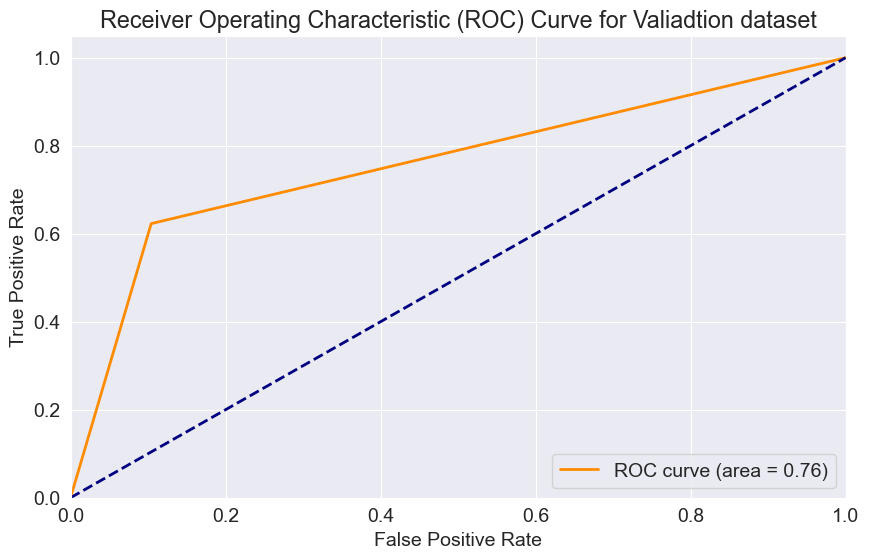

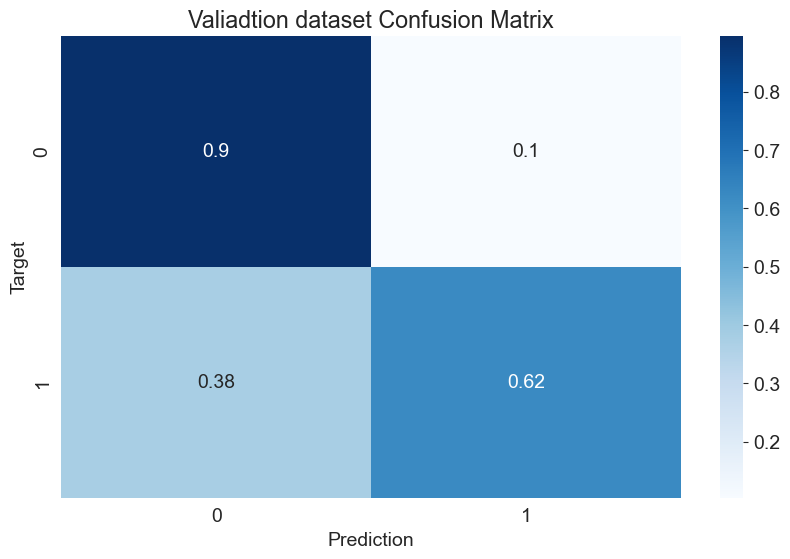

In [11]:
val_preds = model.predict(X_val)
plot_roc_auc_and_confusion_matrix(y_val, val_preds, "Valiadtion dataset")

Отже бачимо, що якість моделі на навчальних даних за метрикою area under ROC становить 100%, в той час як на валідаційному наборі даних всього 76%, тому можна зробити висновок, що модель перенавчилась.

In [12]:
model.tree_.max_depth

22

У нас вийшла глибина дерева 22 вузли. Немало, якраз можна встигнути перенавчитись:)

Будуємо дерево глибиною в 2 вузли.

In [13]:
model_002 = DecisionTreeClassifier(random_state=42, max_depth=2)
model_002.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

Area under ROC score on Train dataset decision tree with depth=2 dataset: 0.72


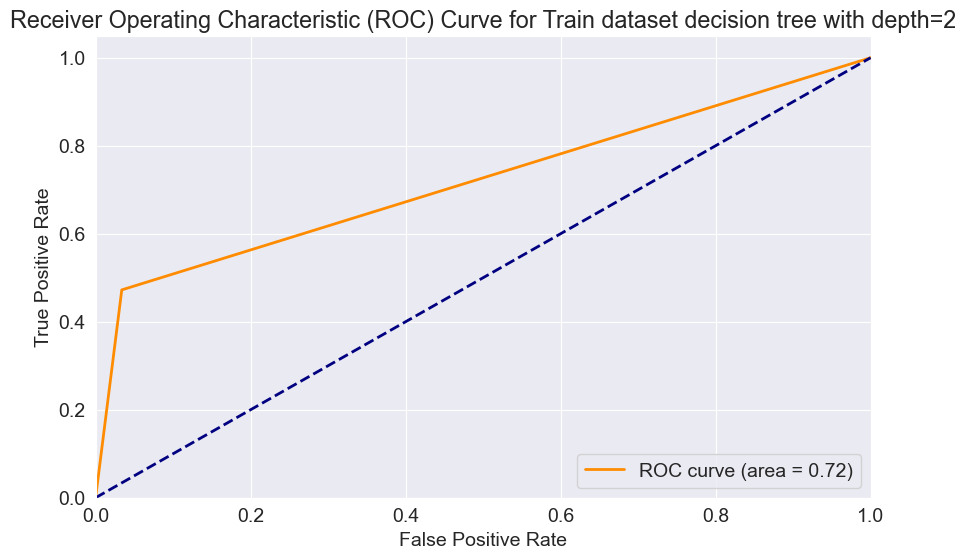

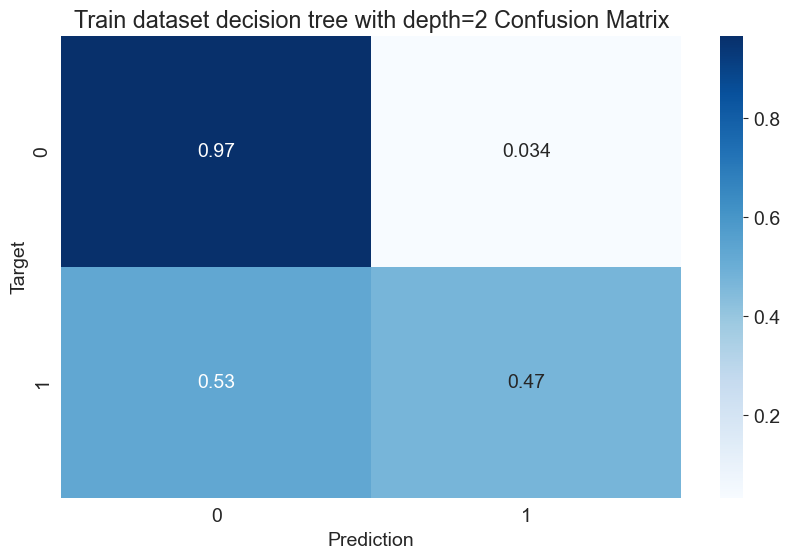

In [14]:
train_preds_002 = model_002.predict(X_train)
plot_roc_auc_and_confusion_matrix(y_train, train_preds_002, "Train dataset decision tree with depth=2")

Area under ROC score on Validation dataset decision tree with depth=2 dataset: 0.71


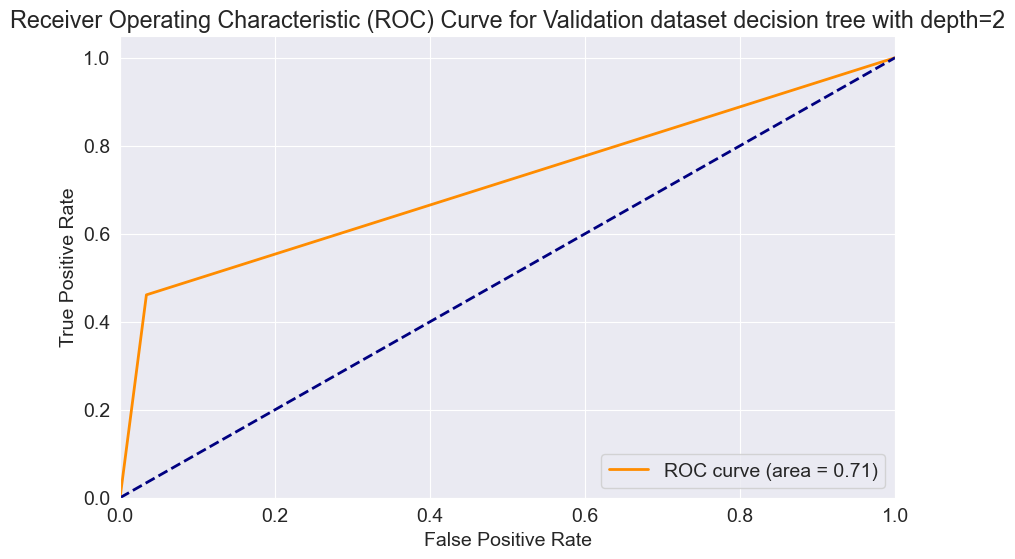

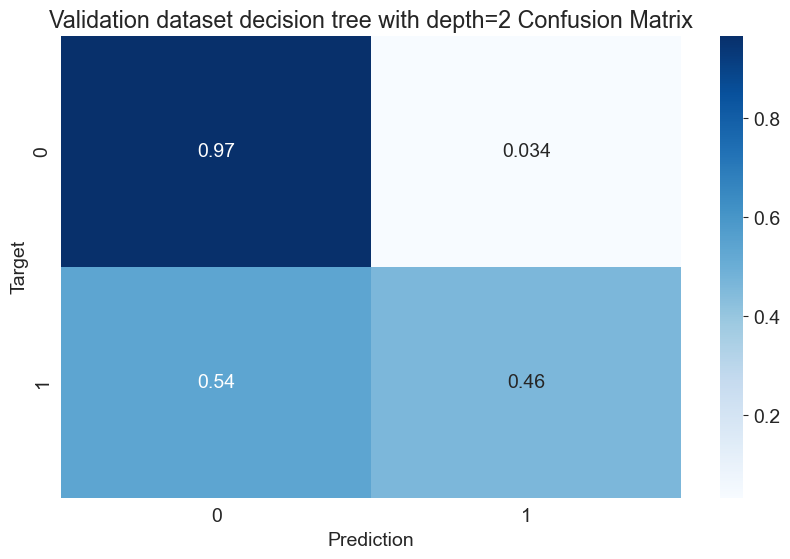

In [15]:
val_preds_002 = model_002.predict(X_val)
plot_roc_auc_and_confusion_matrix(y_val, val_preds_002, "Validation dataset decision tree with depth=2")

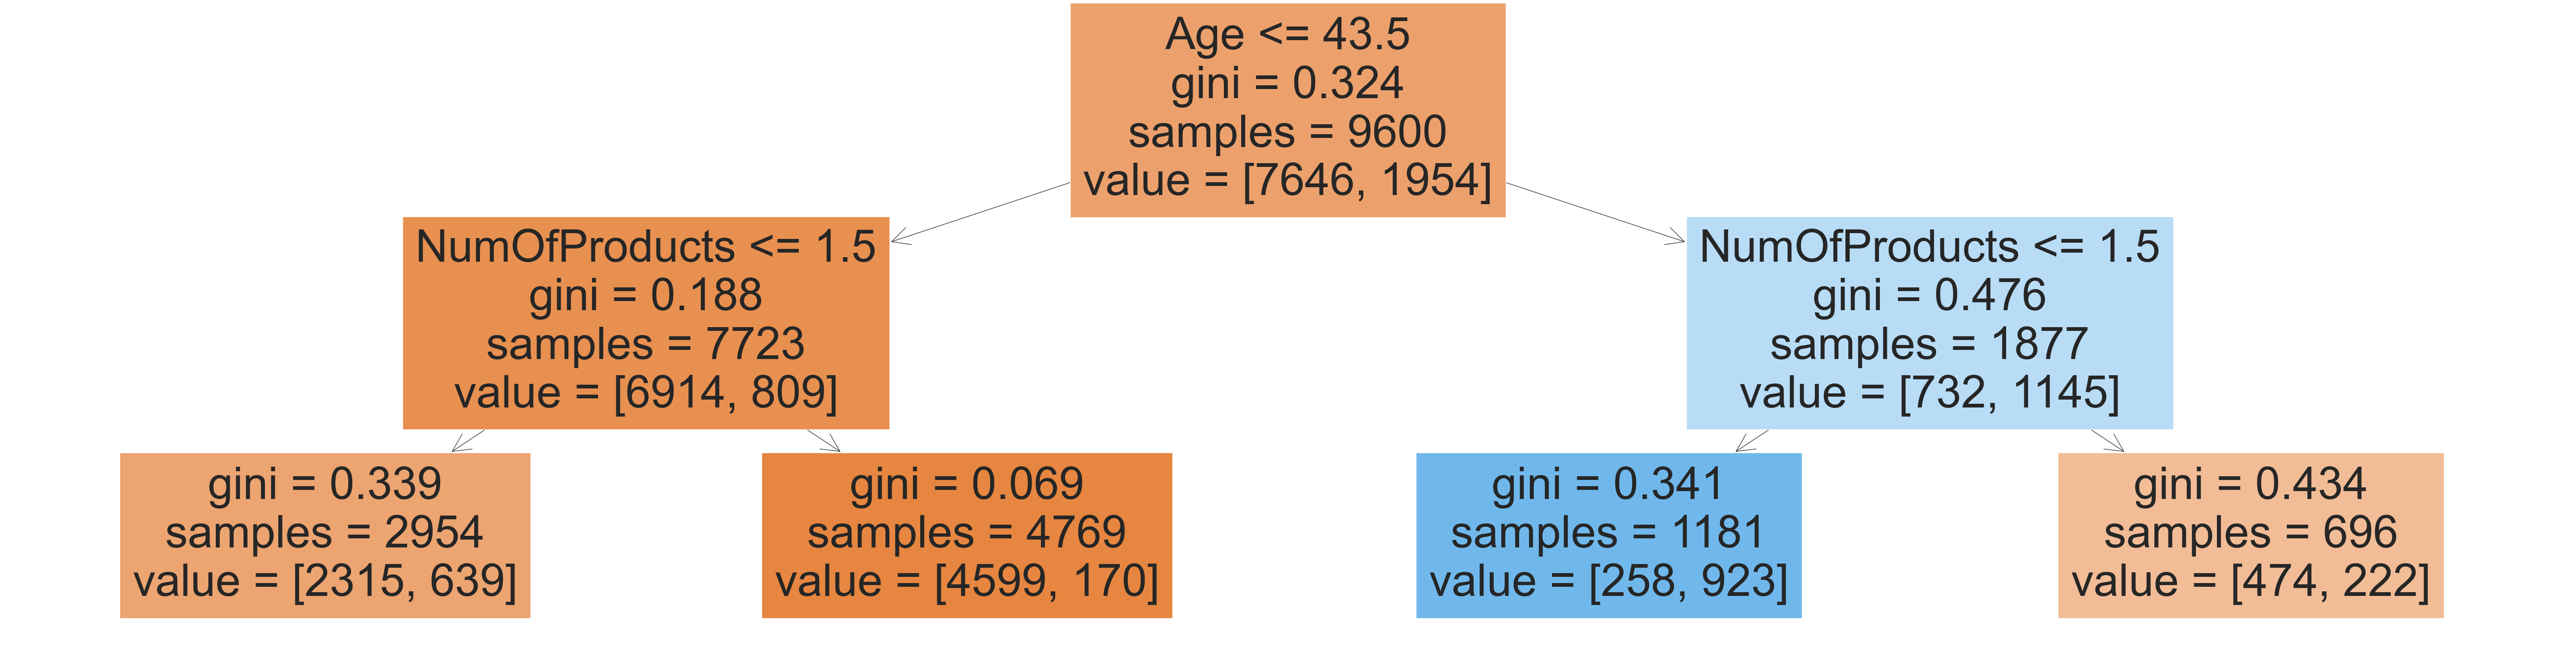

In [16]:
plt.figure(figsize=(80,20))
plot_tree(model_002, feature_names=X_train.columns, filled=True);

In [17]:
tree_text = export_text(model, feature_names=list(X_train.columns))
print(tree_text[:5000])

|--- Age <= 43.50
|   |--- NumOfProducts <= 1.50
|   |   |--- Age <= 39.50
|   |   |   |--- Geography_encoded <= 0.20
|   |   |   |   |--- Age <= 38.50
|   |   |   |   |   |--- Age <= 33.50
|   |   |   |   |   |   |--- CreditScore <= 512.00
|   |   |   |   |   |   |   |--- Balance <= 94331.40
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- Balance >  94331.40
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- CreditScore >  512.00
|   |   |   |   |   |   |   |--- Age <= 29.50
|   |   |   |   |   |   |   |   |--- Tenure <= 6.50
|   |   |   |   |   |   |   |   |   |--- EstimatedSalary <= 179127.00
|   |   |   |   |   |   |   |   |   |   |--- EstimatedSalary <= 66036.34
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- EstimatedSalary >  66036.34
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |   |   |   |   |   |-

In [18]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model_002.feature_importances_
}).sort_values('importance', ascending=False)

In [19]:
importance_df.head(10)

,feature,importance
1,Age,0.715546
4,NumOfProducts,0.284454
0,CreditScore,0.000000
2,Tenure,0.000000
3,Balance,0.000000
5,HasCrCard,0.000000
6,IsActiveMember,0.000000
7,EstimatedSalary,0.000000
8,Geography_encoded,0.000000
9,Gender_Type_Code,0.000000


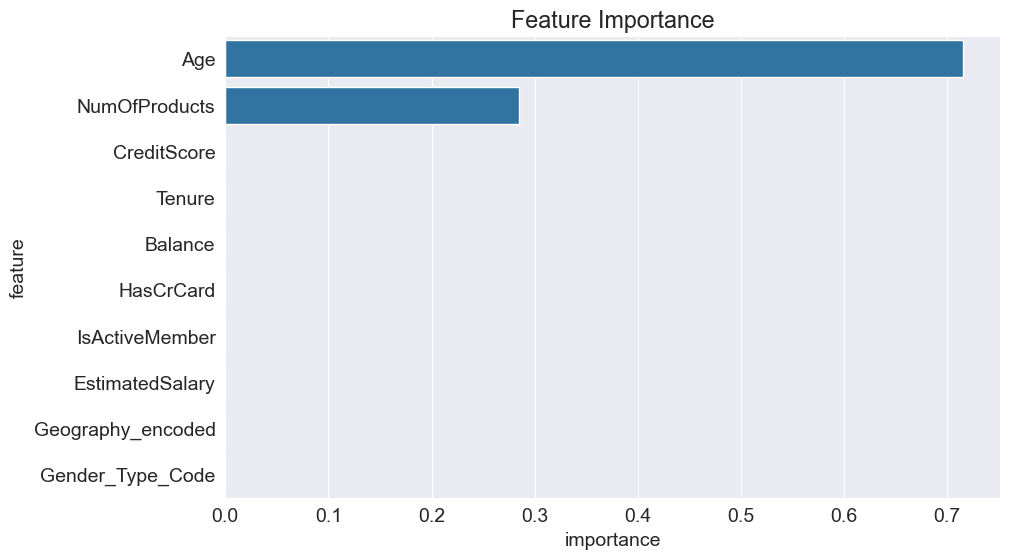

In [20]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

Отже, ми натренували другу модель з глубиною дерева 2, і бачимо, що тут вже на навчальному і валідаційних датасетах метрика ROC становить 71-72%, що означає, що моделька не перенавчилась і у нас сталбільні результати модельки на валідаційному і на тестовому датафреймах.
Найважливішими ознаками для передбачення відтоку клаєнтів банку виявились Вік та Кількість продуктів.

**Завдання 3**. Спробуйте знайти такі параметри моделі `DecisionTree` аби модель генералізувала ліпше (був вищий показник AUROC на валідаційній вибірці). Проекспериментуйте з різними значеннями параметрів `max_leaf_nodes`, `max_depth` та лишіть ті, які дають найкращий результат, разом з відповідними AUROC на тренувальній і валідаційній вибірках.

В цьому завданні спробуйте просто знайти параметри методом "тика" :)

Area under ROC score on Train dataset decision tree find best dataset: 0.83


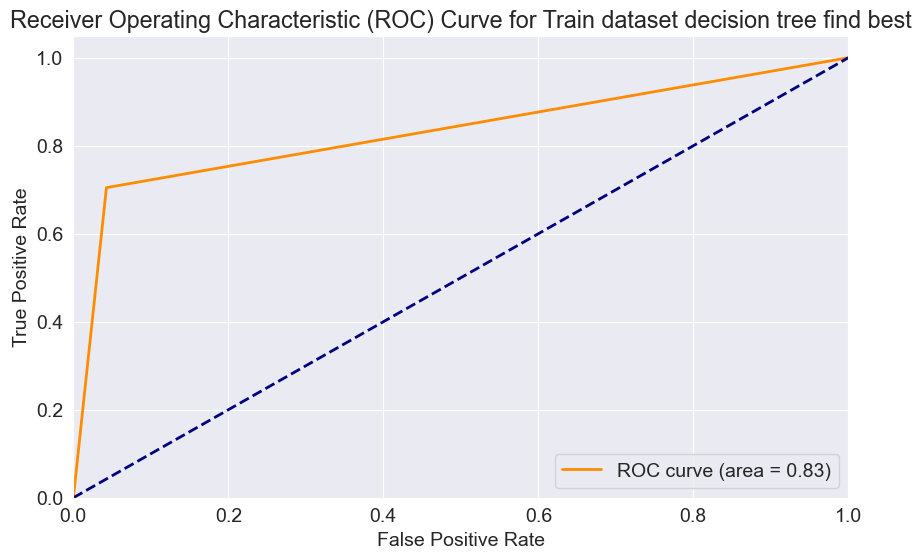

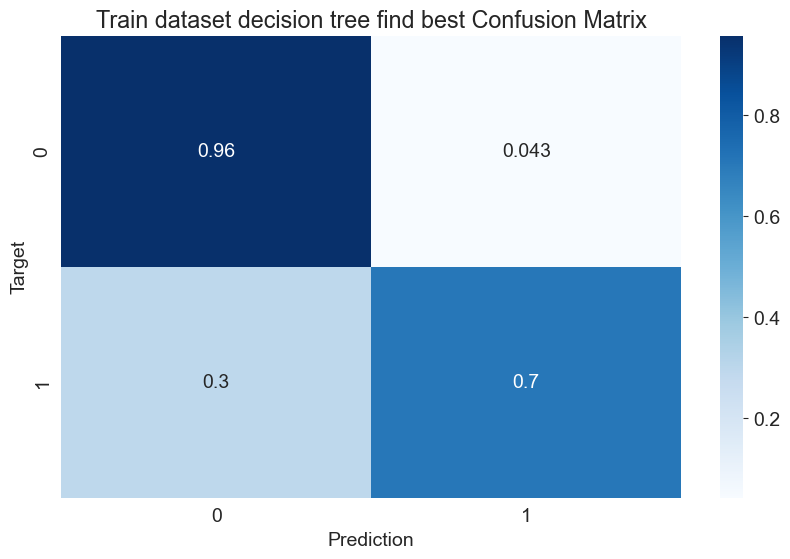

Area under ROC score on Validation dataset decision tree find best dataset: 0.81


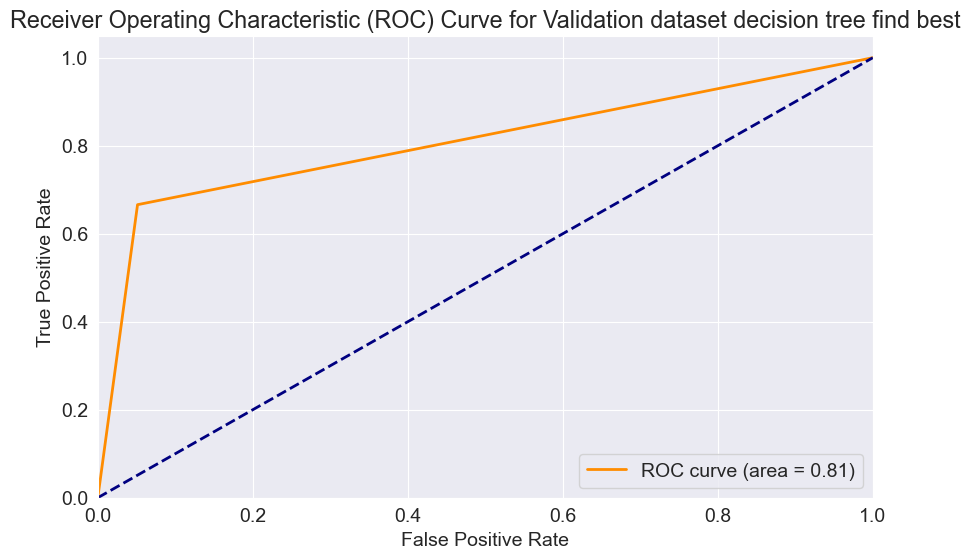

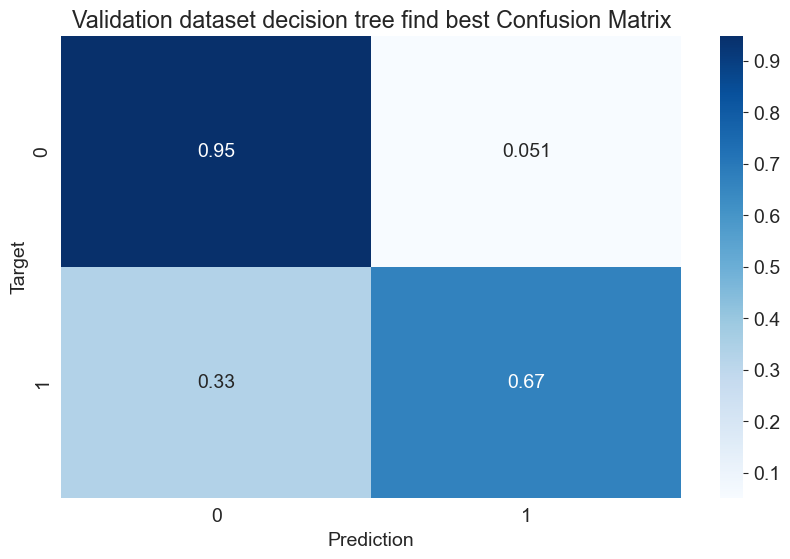

In [21]:
model_find_best = DecisionTreeClassifier(random_state=42, max_depth=6, max_leaf_nodes=100)
model_find_best.fit(X_train, y_train)

train_preds_find_best = model_find_best.predict(X_train)
plot_roc_auc_and_confusion_matrix(y_train, train_preds_find_best, "Train dataset decision tree find best")

val_preds_find_best = model_find_best.predict(X_val)
plot_roc_auc_and_confusion_matrix(y_val, val_preds_find_best, "Validation dataset decision tree find best")

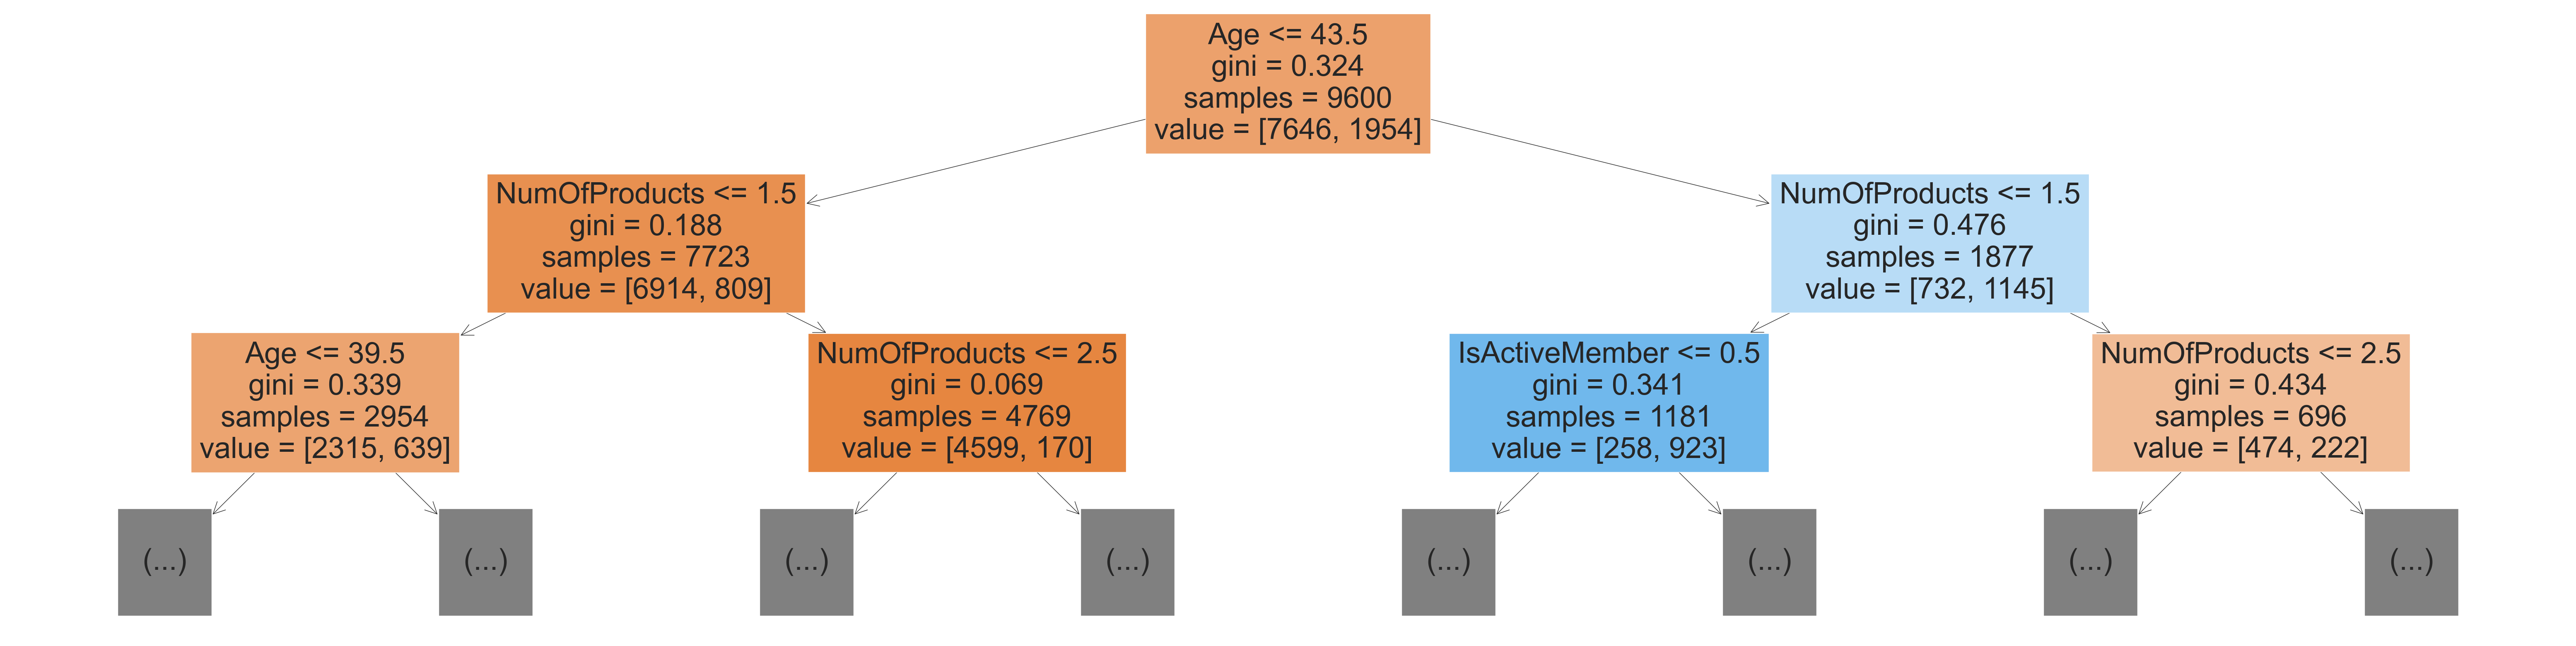

In [22]:
plt.figure(figsize=(80,20))
plot_tree(model_find_best, feature_names=X_train.columns, max_depth=2, filled=True);

In [23]:
importance_df_find_best = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model_find_best.feature_importances_
}).sort_values('importance', ascending=False)
importance_df_find_best.head(10)

,feature,importance
1,Age,0.546610
4,NumOfProducts,0.302776
3,Balance,0.055958
6,IsActiveMember,0.053475
8,Geography_encoded,0.029950
9,Gender_Type_Code,0.004737
7,EstimatedSalary,0.004420
0,CreditScore,0.001213
2,Tenure,0.000861
5,HasCrCard,0.000000


Поки що методом тику накраща модель виходить, якщо взяти такі параметри max_depth=6, max_leaf_nodes=100, метрика AUROC стабільна на навчальному і валідаційному датасетах і знаходиться на рівні 81-83%.

**Завдання 4**. В циклі пройдіться по значенням max_depth від 1 до 20 включно, на кожній ітерації натренуйте DecisionTree модель і виміряйте AUROC на трейн і валідаційних даних.

В кінці виведіть на графік залеєність між AUROC на трейн і валідаційних даних і номером ітерації.

In [24]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_train, y_train)
    
    y_train_preds = model.predict(X_train)
    train_fpr, train_tpr, threshold = roc_curve(y_train, y_train_preds, pos_label=1)
    train_roc_auc = auc(train_fpr, train_tpr)
    
    y_val_preds = model.predict(X_val)
    val_fpr, val_tpr, threshold = roc_curve(y_val, y_val_preds, pos_label=1)
    val_roc_auc = auc(val_fpr, val_tpr)
    
    return {'Max Depth': md, 'Training AUROC': train_roc_auc, 'Validation AUROC': val_roc_auc}

In [25]:
%%time
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])

Wall time: 726 ms


In [26]:
errors_df.style.background_gradient(subset='Validation AUROC', cmap='Blues_r')

,Max Depth,Training AUROC,Validation AUROC
0,1,0.745121,0.739883
1,2,0.719311,0.713535
2,3,0.760306,0.750660
3,4,0.788738,0.769540
4,5,0.822165,0.806340
5,6,0.831036,0.806340
6,7,0.841234,0.807060
7,8,0.855990,0.806558
8,9,0.875193,0.810352
9,10,0.883441,0.793697


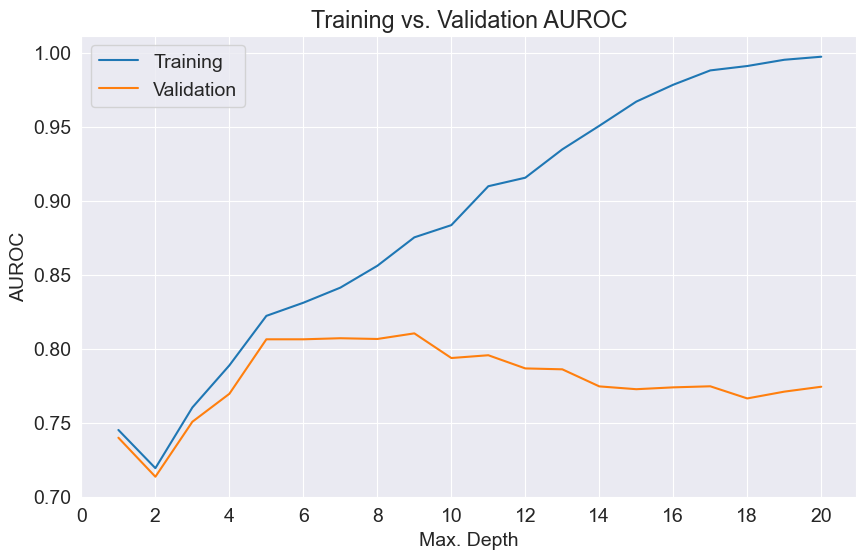

In [27]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training AUROC'])
plt.plot(errors_df['Max Depth'], errors_df['Validation AUROC'])
plt.title('Training vs. Validation AUROC')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('AUROC')
plt.legend(['Training', 'Validation']);

Висновок: Виходить, що найкраща якість оясягається на глибині в 9 вузлів

**Завдання 5**.
1. Натренуйте модель `DecisionTree` з найкращим значенням `max_depth`, яке ви знайшли на попередній ітерації.
2. Завантажте тестові дані змагання з `test.csv`.
3. Зробіть попередню обробку даних з функцією `preprocess_new_data` з вашого модуля `process_bank_churn.py`.
4. Зробіть передбачення використовуючи цю модель на тестових даних змагання.
5. Сформуйте `submission.csv`.
6. Зробіть новий Submission на Kaggle і додайте тут скріншот Вашого скору на паблік лідерборді :)


In [33]:
model_best = DecisionTreeClassifier(random_state=42, max_depth=9)
model_best.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9, random_state=42)

Area under ROC score on Train dataset decision tree with depth=9 dataset: 0.88


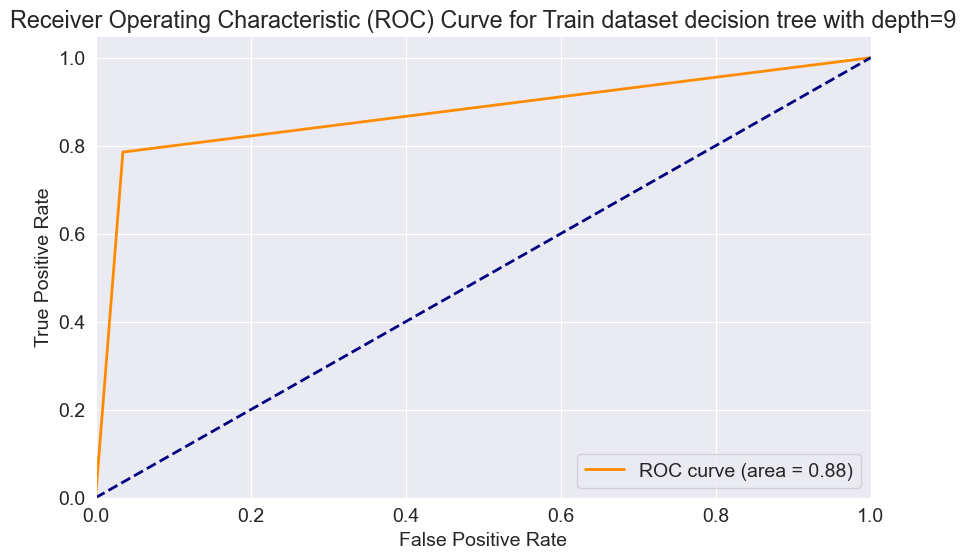

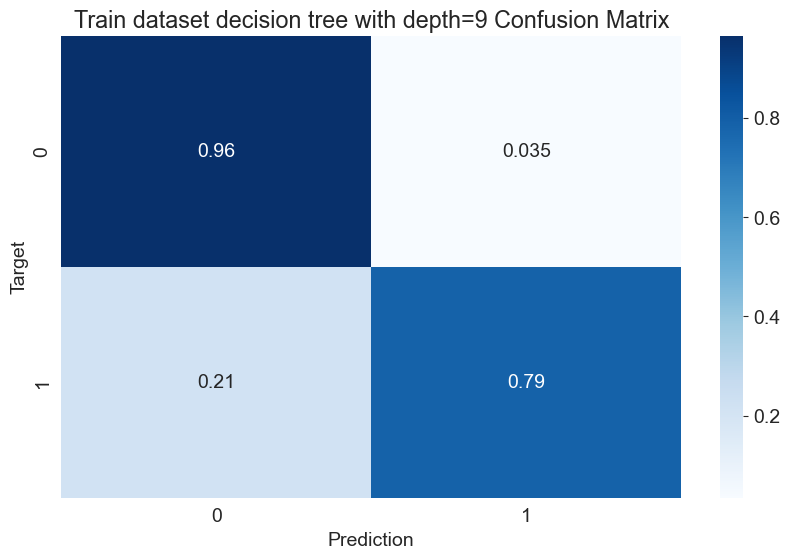

In [35]:
train_preds_best = model_best.predict(X_train)
plot_roc_auc_and_confusion_matrix(y_train, train_preds_best, "Train dataset decision tree with depth=9")

Area under ROC score on Validation dataset decision tree with depth=9 dataset: 0.81


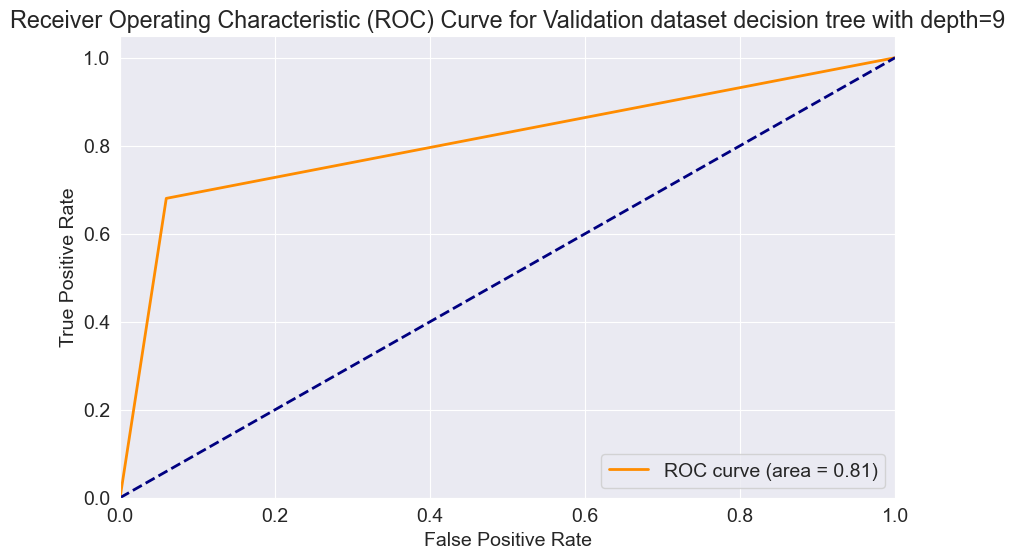

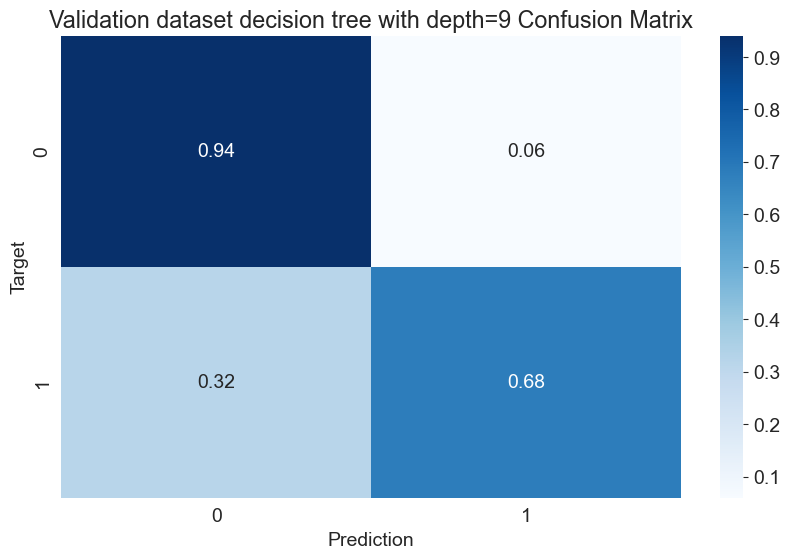

In [36]:
val_preds_best = model_best.predict(X_val)
plot_roc_auc_and_confusion_matrix(y_val, val_preds_best, "Validation dataset decision tree with depth=9")

Ми натренували модель з глибиною в 9 вузлів, отримали якість 81% за метрикою AUROC, далі зчитаємо тестові дані та зробимо предікт.

In [68]:
test_df = pd.read_csv('bank-customer-churn-prediction-dlu/test.csv', index_col=0)

In [72]:
test_df

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,,,
15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86
15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28
15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45
15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87
15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97
...,...,...,...,...,...,...,...,...,...,...,...,...
24995,15642997.0,Chukwumaobim,639.0,Spain,Male,38.0,10.0,0.00,2.0,1.0,1.0,49637.65
24996,15739271.0,Clements,678.0,Spain,Male,39.0,9.0,0.00,2.0,1.0,1.0,142513.50
24997,15756743.0,Chidiebere,774.0,France,Male,30.0,9.0,0.00,2.0,1.0,0.0,4861.72


In [70]:
preprocessed_test_df = preprocess_new_data(test_df.copy(), scaler=scaler, imputer=imputer)

In [71]:
preprocessed_test_df

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_encoded,Gender_Type_Code
0,584.0,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0.1834,1.0
1,551.0,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,0.5955,1.0
2,706.0,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,0.5955,1.0
3,717.0,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,0.2211,1.0
4,592.0,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0.2211,1.0
...,...,...,...,...,...,...,...,...,...,...
9995,639.0,38.0,10.0,0.00,2.0,1.0,1.0,49637.65,0.2211,1.0
9996,678.0,39.0,9.0,0.00,2.0,1.0,1.0,142513.50,0.2211,1.0
9997,774.0,30.0,9.0,0.00,2.0,1.0,0.0,4861.72,0.5955,1.0
9998,595.0,38.0,6.0,144875.79,1.0,1.0,0.0,126469.09,0.5955,1.0


In [73]:
preprocessed_test_df.index = test_df.index

In [74]:
preprocessed_test_df

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_encoded,Gender_Type_Code
id,,,,,,,,,,
15000,584.0,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0.1834,1.0
15001,551.0,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,0.5955,1.0
15002,706.0,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,0.5955,1.0
15003,717.0,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,0.2211,1.0
15004,592.0,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0.2211,1.0
...,...,...,...,...,...,...,...,...,...,...
24995,639.0,38.0,10.0,0.00,2.0,1.0,1.0,49637.65,0.2211,1.0
24996,678.0,39.0,9.0,0.00,2.0,1.0,1.0,142513.50,0.2211,1.0
24997,774.0,30.0,9.0,0.00,2.0,1.0,0.0,4861.72,0.5955,1.0


In [75]:
test_df['Exited'] = model_best.predict(preprocessed_test_df)

In [77]:
test_df['Exited'].value_counts()

0.0    8101
1.0    1899
Name: Exited, dtype: int64

In [86]:
sample_submission = pd.read_csv('bank-customer-churn-prediction-dlu/sample_submission.csv', index_col=0)

In [87]:
sample_submission

,Exited
id,
15000,0.5
15001,0.5
15002,0.5
15003,0.5
15004,0.5
...,...
24995,0.5
24996,0.5
24997,0.5


In [88]:
sample_submission = sample_submission.drop(columns=['Exited'])
sample_submission = sample_submission.join(test_df['Exited'])

In [89]:
sample_submission

,Exited
id,
15000,0.0
15001,0.0
15002,0.0
15003,1.0
15004,0.0
...,...
24995,0.0
24996,0.0
24997,0.0


In [91]:
sample_submission['Exited'].value_counts()

0.0    8101
1.0    1899
Name: Exited, dtype: int64

In [92]:
sample_submission.to_csv('bank-customer-churn-prediction-dlu/submission_decision_tree.csv')

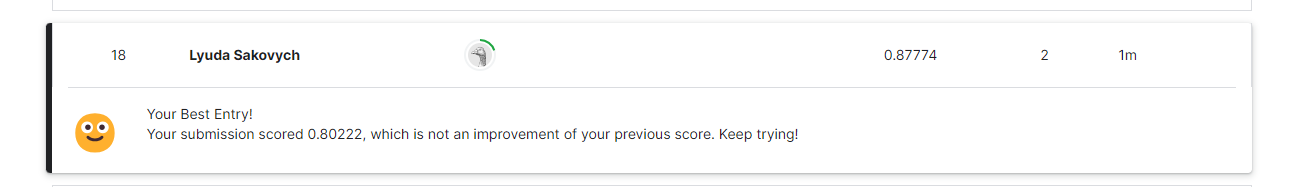

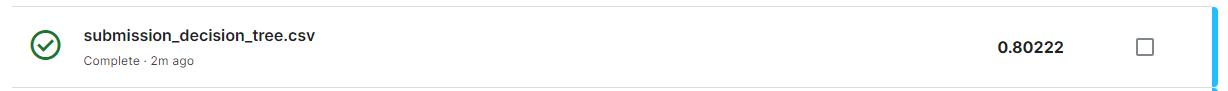